In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 0)

## Exploratory Data Analysis (EDA)

In this notebook, we will invesigate some of the patterns in the data, and performing some insightful visualization into the Airbnb market in Vancouver.

Our hope is that this will lead to hypothesize some important questions that can be deduced from the data above

### Import Datasets

We will first import the processed datasets obtained from the preprocessing step we have done before

In [2]:
# Import datasets
df_listings = pd.read_csv('../data/processed/listings_processed.csv', parse_dates = ['host_since', 'first_review', 'last_review'])
df_calendar = pd.read_csv('../data/processed/calendar_processed.csv', parse_dates = ['date'])
df_reviews = pd.read_csv('../data/processed/reviews_processed.csv', parse_dates = ['date'])

In [3]:
# Import geometry for plotting using geopandas
df_places = gpd.read_file('../data/processed/neighbourhoods.geojson')
df_places.drop(['neighbourhood_group'], axis = 1, inplace = True)

### Categorizing Features

We will split the features of our listings dataset into three different categories: `datetime`, `numeric`, and `categorical`

In [4]:
# Seperate datetime, numeric and categorical columns in df_listings
datetime_cols = df_listings.select_dtypes(include = ['datetime']).columns
numeric_cols = df_listings.select_dtypes(include = ['number']).columns
categorical_cols = df_listings.select_dtypes(include = ['object']).columns

### Pricing Distribution

It is very informative to first look at the general distribution of pricing across different AirBnb listings

<Axes: xlabel='price'>

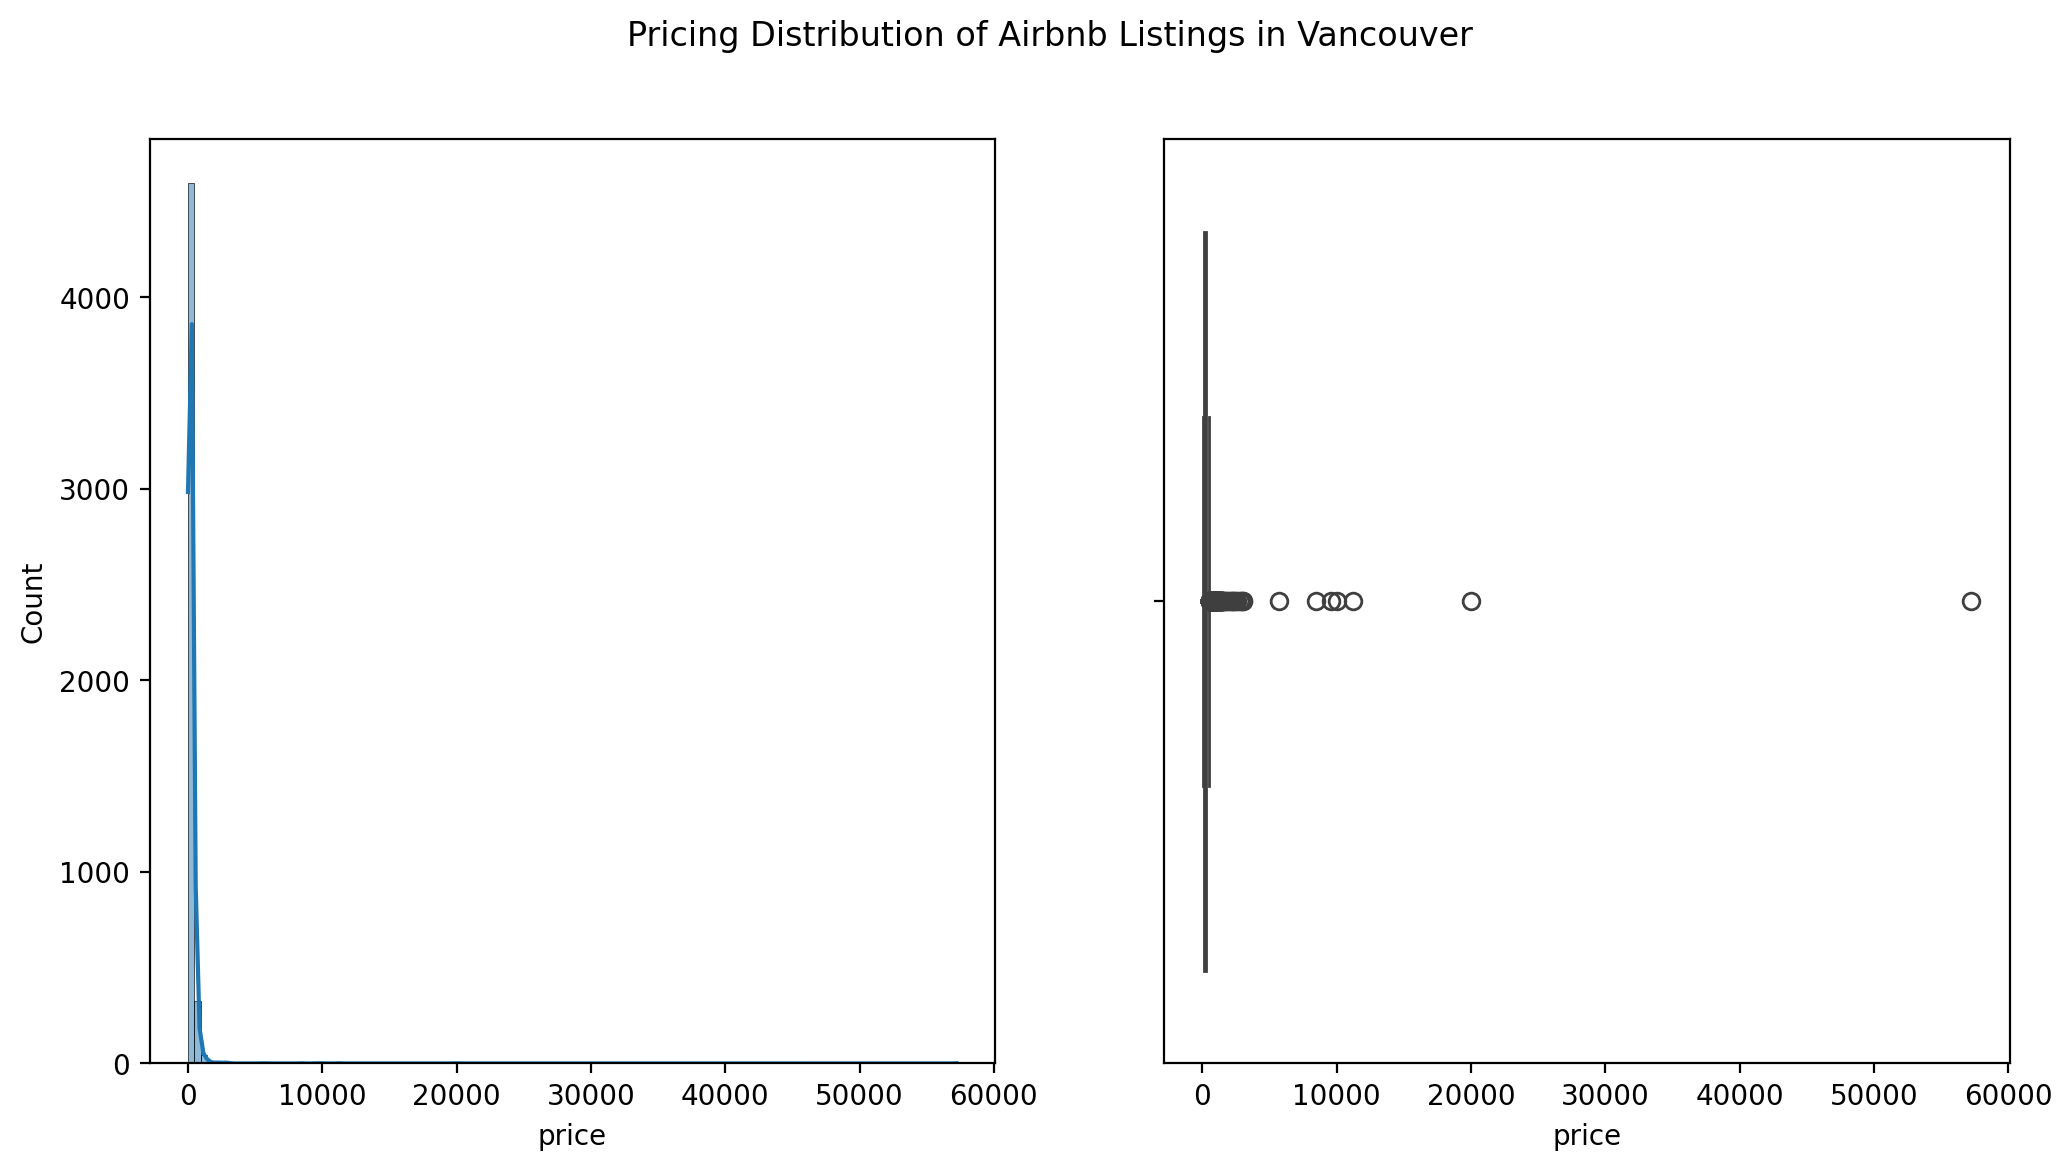

In [5]:
# Pricing distribution

plt.figure(figsize = (12,6), dpi = 200)
plt.suptitle('Pricing Distribution of Airbnb Listings in Vancouver')
plt.subplot(1,2,1)
sns.histplot(data = df_listings, x = 'price', bins = 120, kde = True)

plt.subplot(1,2,2)
sns.boxplot(data = df_listings, x = 'price')

### Outlier Detection using Tukey's Fence

We wish to consider the pricing distribution more in detail by deciding on an approriate cutoff that could be used for visualization. To do so, we will use a common method called Tukey's fence to detect outliers in our dataset

The principles of Tukey's fence relies on using the **Interquantile Range (IQR)** to determine the bulk of the data for any distribution.
 
Datapoints are considered by the filter as outliers if the value is higher than some multiplier of the IQR from the 25 and 75 percentiles. The common value for this multiplier is 1.5 for outliers and 3 for far outliers. In this context, we will choose 3 just for the sake of broader visualizations

Note that we are only identifying outliers in the context of visualization only. More justifications are needed to determine whether to impute these datapoints from the dataset

In [6]:
def IQR_filter(series, mult):
    
    # Calculate IQR
    q1 = np.percentile(series.dropna(), 25)
    q3 = np.percentile(series.dropna(), 75)
    iqr = q3 - q1

    # Construct boolean mask
    data_range = (q1 - mult * iqr, q3 + mult * iqr)
    non_outliers_mask = (series >= data_range[0]) & (series <= data_range[1])

    # Print results
    print('-------- IQR Filter Results -------')
    print(f'25th percentile: {q1}')
    print(f'75th percentile: {q3}')
    print(f'Interquantile Range (IQR): {iqr}\n')
    print(f'Cutoff Range (with a multiplier of {mult}):')
    print(data_range)

    return data_range


In [7]:
iqr_range = IQR_filter(df_listings['price'], 3)

-------- IQR Filter Results -------
25th percentile: 128.0
75th percentile: 290.0
Interquantile Range (IQR): 162.0

Cutoff Range (with a multiplier of 3):
(np.float64(-358.0), np.float64(776.0))


Using the obtained upper bound, we will visualize the listings up till the cutoff specified by Tukey's Fence

Text(0.5, 0, 'Listing Price ($)')

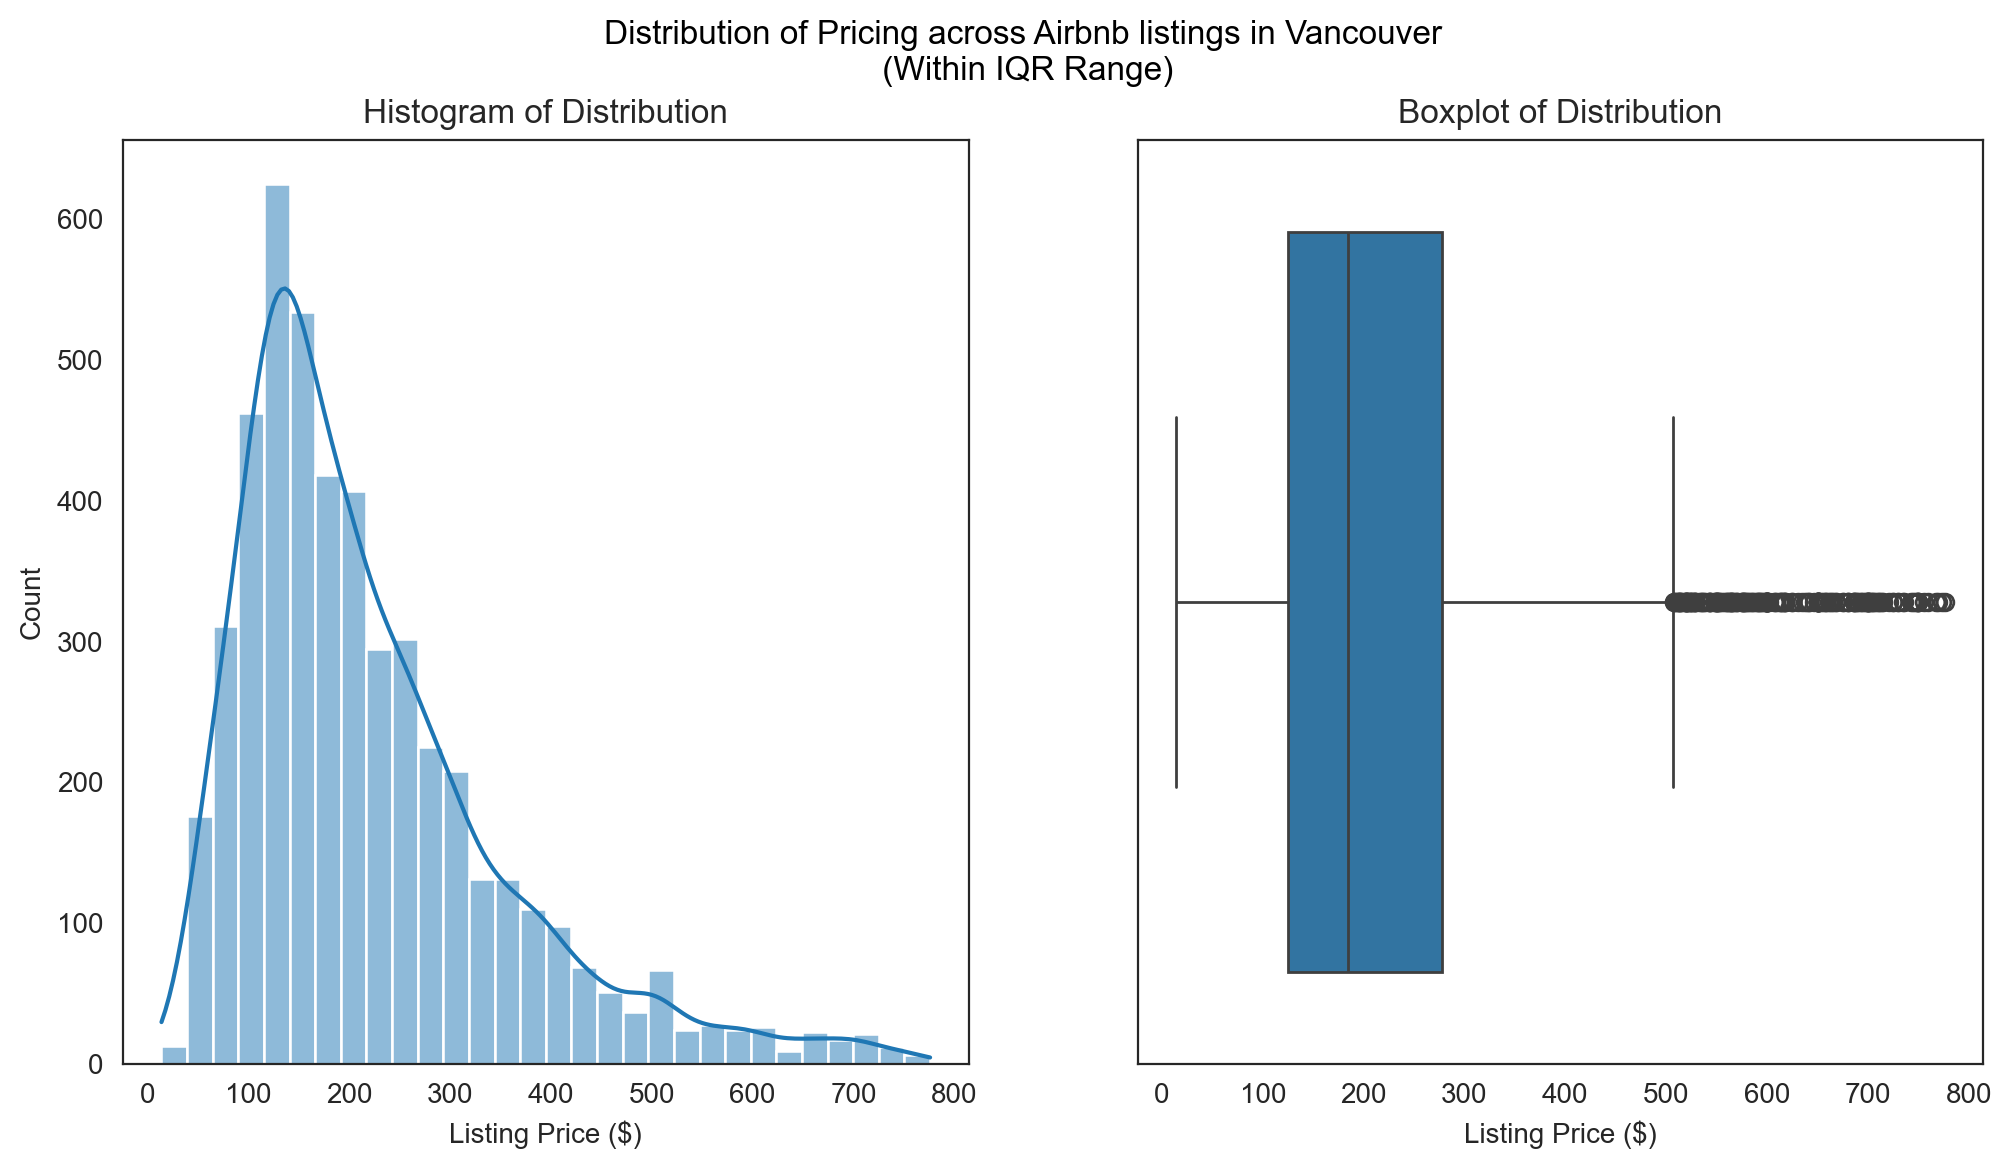

In [8]:
# Pricing distribution below 5000

plt.figure(figsize = (12,6), dpi = 200)
plt.suptitle('Distribution of Pricing across Airbnb listings in Vancouver\n (Within IQR Range)')
sns.set_style('white')

plt.subplot(1,2,1)
plt.title('Histogram of Distribution')
ax1 = sns.histplot(data = df_listings[df_listings['price'] <= iqr_range[1]], x = 'price', bins = 30, kde = True)
ax1.set_title('Histogram of Distribution')
ax1.set_xlabel('Listing Price ($)')
ax1.set_ylabel('Count')

plt.subplot(1,2,2)
plt.title('Boxplot of Distribution')
ax2 = sns.boxplot(data = df_listings[df_listings['price'] <= iqr_range[1]], x = 'price')
ax2.set_xlabel('Listing Price ($)')


### Analysis

- The pricing distribution of Airbnb listings is right-skewed, and closely resembles a lognormal distribution

- The median price of Airbnb lisitings is near $200 per night, which corresponds to $6000 per month

### Distribution of Pricing based on Location



In [9]:
median_pricing = df_listings.groupby('neighbourhood_cleansed').agg({'price' : "median"})
median_pricing = median_pricing.reset_index().sort_values(by = 'price', ascending = False)
median_pricing



,neighbourhood_cleansed,price
1,Downtown,250.0
2,Downtown Eastside,226.0
18,Strathcona,206.0
10,Kitsilano,200.0
21,West End,195.0
12,Mount Pleasant,189.0
16,Shaughnessy,182.5
22,West Point Grey,182.0
17,South Cambie,179.0
0,Arbutus Ridge,175.0


<Axes: xlabel='price', ylabel='neighbourhood_cleansed'>

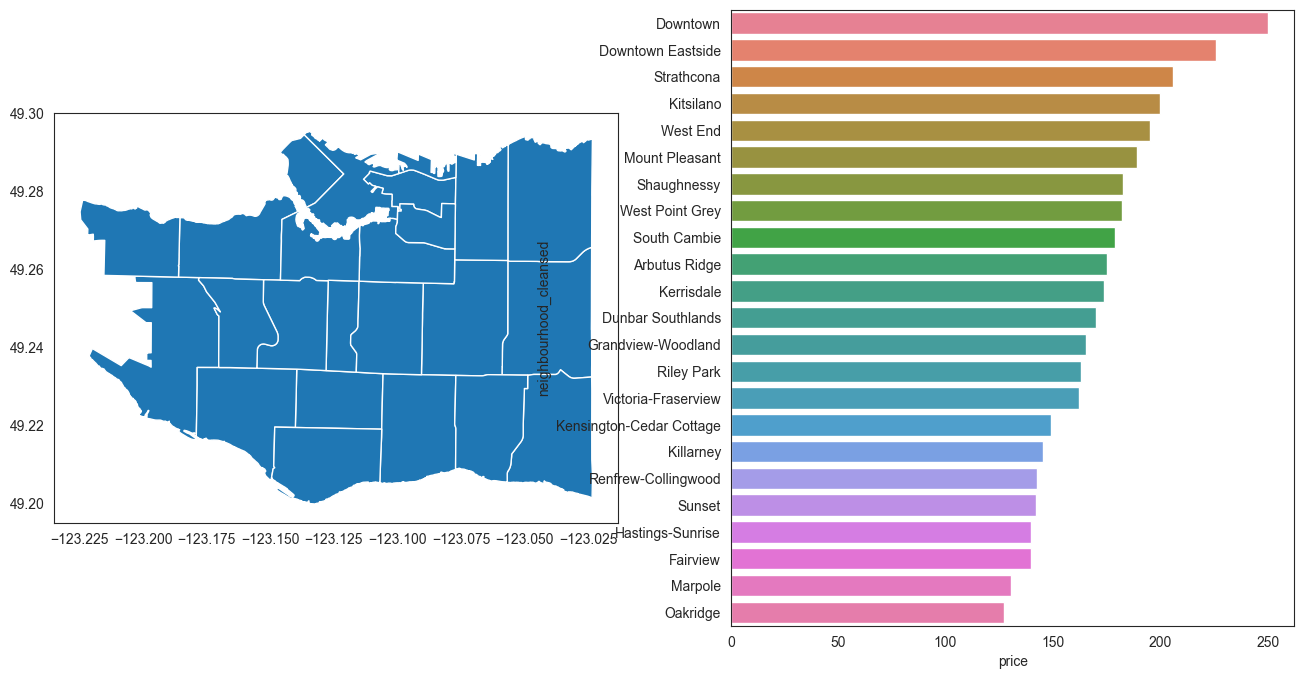

In [10]:
fig, axes = plt.subplots(1,2, figsize = (16,8))
df_places.plot(ax = axes[0], figsize = (8,8))
sns.barplot(ax = axes[1], data = median_pricing, x = 'price', 
            y = 'neighbourhood_cleansed', hue = 'neighbourhood_cleansed')
